## 1. Importing Necessary Libraries ##

In [ ]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13662663125346107520
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12190573450877950669
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6576602082737490609
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9168992074059512346
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## 2. Reading and Visualization of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/My Works/Bangla YouTube/Emotion.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

import nltk
nltk.download('stopwords')
nltk_stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = pd.read_csv(main_directory,encoding = 'utf-8',sep=';')
dataset.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,id,text,emotion,lan,domain
0,7011,Ethan Robin 2018 teo still shuntei achi\n,joy,EN,music_video
1,11698,by Allah apnake aro biggo koruk\n,joy,RN,talkshow_video
2,25617,Inshaallah\n,none,RN,talkshow_video
3,24691,ভুয়ো মুক্তি যোদ্ধায় দেশ ভর্তি ।দেশে গেরামে গি...,anger,BN,talkshow_video
4,14097,বুয়া কথা\n,disgust,BN,report_video


In [ ]:
# Get indexes where lan column has value BN and RN
indexNames = dataset[(dataset['lan'] == 'BN') | (dataset['lan'] == 'RN')].index

# Delete these row indexes from dataFrame
dataset = dataset.drop(indexNames)

In [ ]:
dataset.head()

,id,text,emotion,lan,domain
0,7011,Ethan Robin 2018 teo still shuntei achi\n,joy,EN,music_video
5,23185,Good news\n,joy,EN,news_video
11,15605,Osthir hoica boss\n,joy,EN,drama_video
12,24070,"I support you,,you are right,,thanks,,I want t...",joy,EN,report_video
15,16675,Hahah Youe Say Right\n,joy,EN,drama_video


In [ ]:
emotion = np.array(dataset['emotion'])

In [ ]:
class_values = dataset['emotion'].unique()
print(class_values)

['joy' 'none' 'disgust' 'surprise' 'anger' 'others' 'sad' 'fear']


In [ ]:
dataset.groupby('emotion')['text'].count()

emotion
anger        41
disgust     111
fear          2
joy         276
none        256
others        6
sad          17
surprise     38
Name: text, dtype: int64

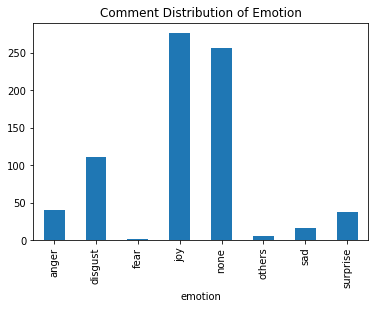

In [ ]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Comment Distribution of Emotion')

In [ ]:
dataset['text']
dataset.head()

,id,text,emotion,lan,domain
0,7011,Ethan Robin 2018 teo still shuntei achi\n,joy,EN,music_video
5,23185,Good news\n,joy,EN,news_video
11,15605,Osthir hoica boss\n,joy,EN,drama_video
12,24070,"I support you,,you are right,,thanks,,I want t...",joy,EN,report_video
15,16675,Hahah Youe Say Right\n,joy,EN,drama_video


In [ ]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy',linewidth=3.0)
    plt.plot(x, val_acc, 'r', label='Validation accuracy',linewidth=3.0)
    plt.title('Training and validation accuracy',fontsize=18)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',linewidth=3.0)
    plt.plot(x, val_loss, 'r', label='Validation loss',linewidth=3.0)
    plt.title('Training and validation loss', fontsize=18)
    plt.legend()


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


## 3. Label Encoding & Vectorization


In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
vocabulary_size = 10000
input_length = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [ ]:
num_classes = len(class_values)
validation_split = 0.1

# 4. Model Creation & Training

# LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000


validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='relu'))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
Total params: 10,441,208
Trainable params: 10,441,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)

Epoch 1/100
120/120 [==============================] - 32s 269ms/step - loss: 0.2971 - accuracy: 0.4025 - f1_m: 0.1741 - precision_m: 0.2688 - recall_m: 0.1375 - val_loss: 0.2942 - val_accuracy: 0.4000 - val_f1_m: 0.2794 - val_precision_m: 0.5333 - val_recall_m: 0.2000
Epoch 2/100
120/120 [==============================] - 33s 271ms/step - loss: 0.2441 - accuracy: 0.6583 - f1_m: 0.5210 - precision_m: 0.7653 - recall_m: 0.4292 - val_loss: 0.3626 - val_accuracy: 0.5167 - val_f1_m: 0.3400 - val_precision_m: 0.5278 - val_recall_m: 0.2583
Epoch 3/100
120/120 [==============================] - 33s 274ms/step - loss: 0.1776 - accuracy: 0.7841 - f1_m: 0.7207 - precision_m: 0.8771 - recall_m: 0.6396 - val_loss: 0.2752 - val_accuracy: 0.4833 - val_f1_m: 0.4053 - val_precision_m: 0.6139 - val_recall_m: 0.3167
Epoch 4/100
120/120 [==============================] - 32s 270ms/step - loss: 0.1031 - accuracy: 0.8637 - f1_m: 0.8481 - precision_m: 0.9472 - recall_m: 0.7875 - val_loss: 0.3264 - val_accur

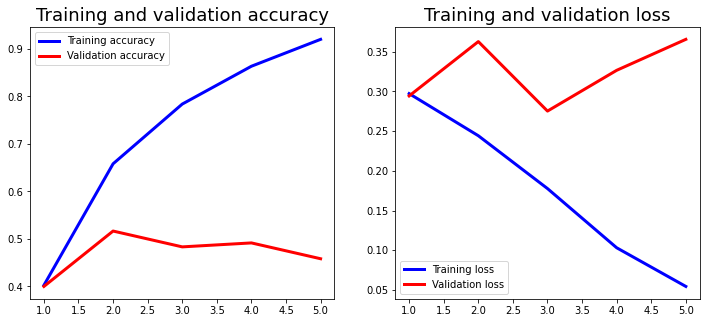

In [ ]:
plot_model(history)

In [ ]:
model_lstm.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 11ms/step - loss: 0.2905 - accuracy: 0.5667 - f1_m: 0.5195 - precision_m: 0.6440 - recall_m: 0.4375


[0.2904532253742218,
 0.5666666626930237,
 0.5194516777992249,
 0.6440137624740601,
 0.4375]

In [ ]:
model_lstm.save('/content/drive/My Drive/My Works/Bangla YouTube/model_lstm_english2.h5')

# Stacked LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
dense_3 (Dense)              (None, 30, 1000)          1001000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           578048    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 11,628,976
Trainable params: 11,628,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)



Epoch 1/100
120/120 [==============================] - 52s 429ms/step - loss: 0.2822 - accuracy: 0.4319 - f1_m: 0.2011 - precision_m: 0.3174 - recall_m: 0.1583 - val_loss: 0.2782 - val_accuracy: 0.5167 - val_f1_m: 0.2854 - val_precision_m: 0.5722 - val_recall_m: 0.2000
Epoch 2/100
120/120 [==============================] - 51s 423ms/step - loss: 0.1962 - accuracy: 0.6918 - f1_m: 0.6357 - precision_m: 0.7639 - recall_m: 0.5688 - val_loss: 0.3110 - val_accuracy: 0.5250 - val_f1_m: 0.4690 - val_precision_m: 0.5333 - val_recall_m: 0.4250
Epoch 3/100
120/120 [==============================] - 51s 429ms/step - loss: 0.1400 - accuracy: 0.7904 - f1_m: 0.7675 - precision_m: 0.8618 - recall_m: 0.7125 - val_loss: 0.3684 - val_accuracy: 0.4333 - val_f1_m: 0.4256 - val_precision_m: 0.4917 - val_recall_m: 0.3917


In [ ]:
model.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 18ms/step - loss: 0.3277 - accuracy: 0.5467 - f1_m: 0.5083 - precision_m: 0.5613 - recall_m: 0.4648


[0.32767030596733093,
 0.54666668176651,
 0.5082852244377136,
 0.5613244771957397,
 0.46477270126342773]

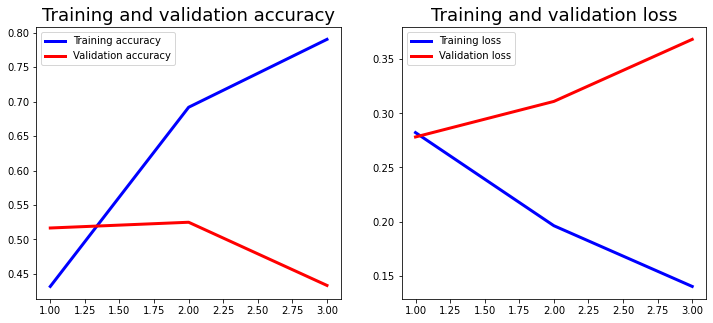

In [ ]:
plot_model(history)

In [ ]:
model.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_english2.h5')

# Stacked LSTM with CNN using pretrained vector

In [ ]:
glove_dir =  '/content/drive/My Drive/My Works/Spam Filtering/glove.6B.100d.txt'

In [ ]:
output_dim=100

In [ ]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='tanh'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='tanh'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='tanh'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='tanh'))

model_glove.add(Dense(8, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_glove.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 30, 100)           10100     
_________________________________________________________________
conv1d (Conv1D)              (None, 27, 100)           40100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 64)             42240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)               

Epoch 1/100
120/120 [==============================] - 2s 18ms/step - loss: 0.3063 - accuracy: 0.3606 - f1_m: 0.0086 - precision_m: 0.0090 - recall_m: 0.0083 - val_loss: 0.3011 - val_accuracy: 0.3417 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 1s 10ms/step - loss: 0.2819 - accuracy: 0.3816 - f1_m: 0.0217 - precision_m: 0.0361 - recall_m: 0.0167 - val_loss: 0.2996 - val_accuracy: 0.3917 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
120/120 [==============================] - 1s 11ms/step - loss: 0.2768 - accuracy: 0.4004 - f1_m: 0.1694 - precision_m: 0.3097 - recall_m: 0.1250 - val_loss: 0.2945 - val_accuracy: 0.4583 - val_f1_m: 0.0267 - val_precision_m: 0.0667 - val_recall_m: 0.0167
Epoch 4/100
120/120 [==============================] - 1s 10ms/step - loss: 0.2727 - accuracy: 0.4298 - f1_m: 0.2100 - precision_m: 0.3611 - recall_m: 0.1562 - val_loss: 0.

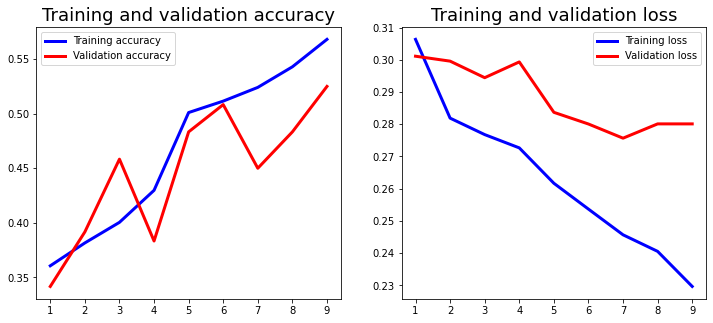

In [ ]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, batch_size=4, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [ ]:
model_glove.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_pretrained_english2.h5')

In [ ]:
model_glove.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 7ms/step - loss: 0.2670 - accuracy: 0.4867 - f1_m: 0.4076 - precision_m: 0.5618 - recall_m: 0.3227


[0.2669510245323181,
 0.4866666793823242,
 0.40755343437194824,
 0.5618253946304321,
 0.3227272629737854]

## 5. Testing all the models with a random text

In [ ]:
test_text = 'wow'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
label_encoder.classes_[np.argmax(model.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_lstm.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'none'

In [ ]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
np.around(model.predict(data), decimals = 2)

array([[0.01, 0.01, 0.  , 0.91, 0.03, 0.  , 0.01, 0.03]], dtype=float32)

In [ ]:
np.around(model_glove.predict(data), decimals = 2)

array([[0.02, 0.07, 0.  , 0.3 , 0.53, 0.01, 0.01, 0.04]], dtype=float32)

In [ ]:
np.around(model_lstm.predict(data), decimals = 2)

array([[0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)